# Задача 2. Определение стоимости авто #

Ключевая метрика RMSE -  среднеквадратичная ошибка. Чтобы сдать проект значение метрики должно быть не более 2500.

# Импортируем необходимые библиотеки 

In [72]:
import warnings
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')


# Подготовка данных #

Откроем и изучим файл

In [73]:
df = pd.read_csv("autos.csv")

In [74]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим типы данных

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Создание описательной статистики

In [76]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


# Удаление неиформативных признаков и изменение названий столбцов

удалим неинформативные признаки

In [77]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 
                  'NumberOfPictures','PostalCode', 'LastSeen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


# Работа со стилем и типами данных

изменим названия столбцов

In [78]:
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 
                'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'date_created']

изменим тип данных в столбцах, где это необходимо

In [79]:
df['date_created'] = pd.to_datetime(df['date_created'])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              354369 non-null  int64         
 1   vehicle_type       316879 non-null  object        
 2   registration_year  354369 non-null  int64         
 3   gearbox            334536 non-null  object        
 4   power              354369 non-null  int64         
 5   model              334664 non-null  object        
 6   kilometer          354369 non-null  int64         
 7   fuel_type          321474 non-null  object        
 8   brand              354369 non-null  object        
 9   repaired           283215 non-null  object        
 10  date_created       354369 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 29.7+ MB


# Работа с пропусками

функция для построения графика, отражающего доли пропусков

In [81]:
def pass_value_barh(df):
    if df.isna().sum().sum() > 0:
        missing_percentage = (df.isna().mean() * 100).to_frame().rename(columns={0: 'space'}).query('space > 0').sort_values(by='space', ascending=True)

        fig, ax = plt.subplots(figsize=(10, 8))
        plot = sns.barplot(x='space', y=missing_percentage.index, data=missing_percentage, palette='viridis')

        ax.set_title('Доля пропусков' + "\n", fontsize=14)
        ax.set_xlabel('Процент пропусков', fontsize=12)
        ax.set_ylabel('Признаки', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        for p in plot.patches:
            width = p.get_width()
            ax.text(width + 0.1, p.get_y() + p.get_height() / 2., f'{width:.2f}%', ha='center', va='center', fontsize=10)

        plt.show()
    else:
        print('Пропусков нет!')

визуализация доли пропусков в каждом столбце

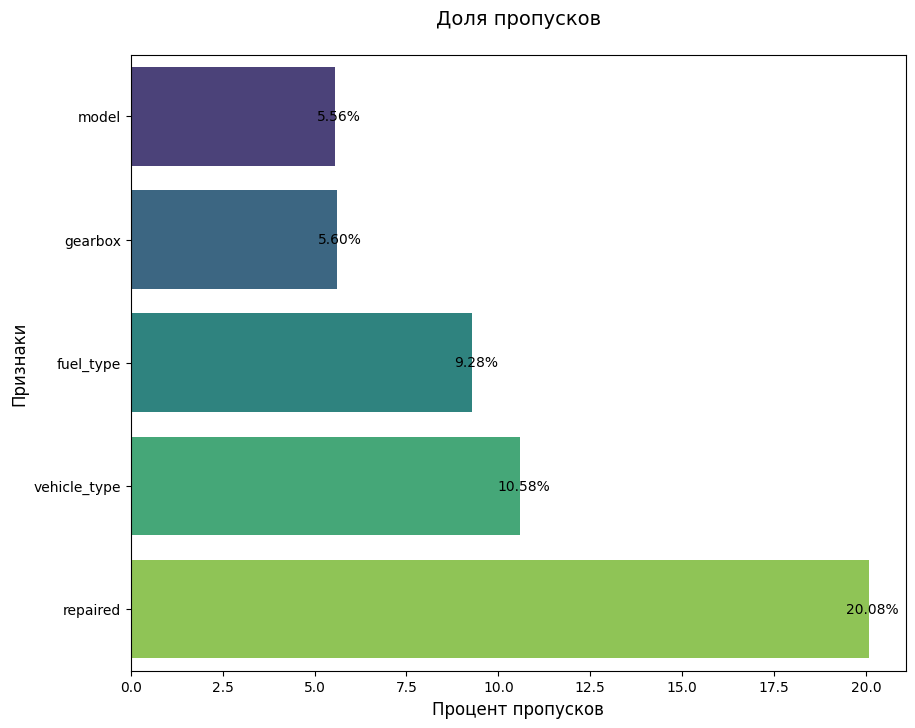

In [82]:
pass_value_barh(df)

заполним пропуски и заменим значения в столбце "repaired"

In [83]:
df['repaired'] = df['repaired'].fillna('no')
df.loc[(df.repaired == 'no'), 'repaired'] = 0
df.loc[(df.repaired == 'yes'), 'repaired'] = 1

df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


заполним пропуски в других столбцах

In [84]:
df = df.fillna('unknown')

In [85]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


проверяем, что пропусков не осталось

In [86]:
pass_value_barh(df)

Пропусков нет!


Для того чтобы упростить анализ данных в нашей лабораторной работе, я решил обработать некоторую информацию в таблице. Если в столбце о ремонте машины были пропущенные значения, мы заменили их на "no". Это делается потому, что, вероятно, при заполнении этого поля, если машина не была в ремонте, могли просто оставлять его пустым.

Далее, чтобы упростить анализ, мы заменили значения "yes" в этом столбце на 1, а "no" на 0.

В остальных столбцах, где у нас были пропущенные значения для категориальных признаков (например, тип кузова, тип топлива, тип коробки передач, модель автомобиля),я решил заполнить их значением "unknown". Таким образом, мы упростили обработку данных и сделали их более однородными для анализа.

# Поиск и удаление дубликатов

Ищем полные дубликаты

In [87]:
df.duplicated().sum()

15062

удаляем полные дубликаты

In [88]:

df = df.drop_duplicates()

df.duplicated().sum()

0

# Работа с аномальными значениями

Посмотрим нет ли аномалий типа: год регистрации автомобиля превышает год публикации объявления

In [89]:
df.loc[df['registration_year'] > df['date_created'].dt.year].shape

(14242, 11)

удалим подобные объекты

In [90]:
df = df.loc[df['registration_year'] <= df['date_created'].dt.year]

# данные по столбцу "год регистрации автомобиля"

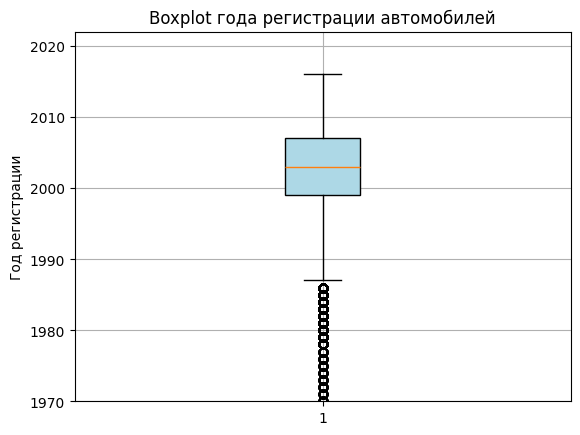

In [167]:
# Boxplot
plt.boxplot(df['registration_year'], patch_artist=True, boxprops=dict(facecolor='#ADD8E6'))
plt.grid()
plt.ylim(1970, 2022)
plt.title('Boxplot года регистрации автомобилей')
plt.ylabel('Год регистрации')
plt.show()

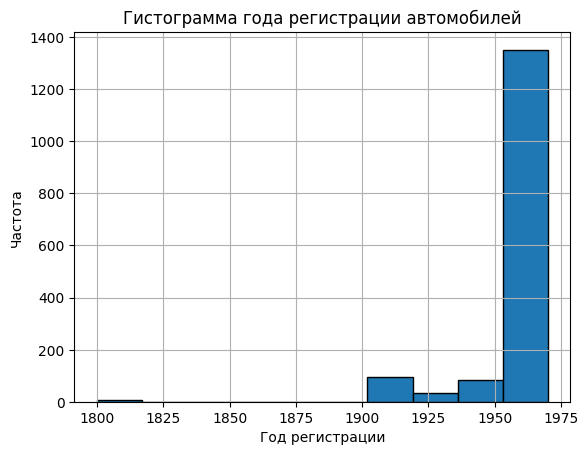

In [92]:
# Гистограмма
plt.hist(df['registration_year'], range=(1800, 1970), bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма года регистрации автомобилей')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.show()

In [93]:
# Вывод максимального года регистрации
print(f'Максимальный год регистрации автомобиля: {df["registration_year"].max()}')

Максимальный год регистрации автомобиля: 2016


In [94]:
# Фильтрация данных
df = df.query('1970 <= registration_year').reset_index(drop=True)

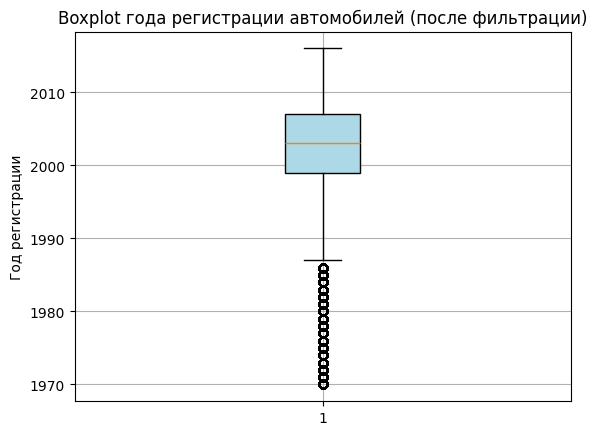

In [95]:
# Boxplot
plt.boxplot(df['registration_year'], patch_artist=True, boxprops=dict(facecolor='#ADD8E6'))
plt.grid()
plt.title('Boxplot года регистрации автомобилей (после фильтрации)')
plt.ylabel('Год регистрации')
plt.show()

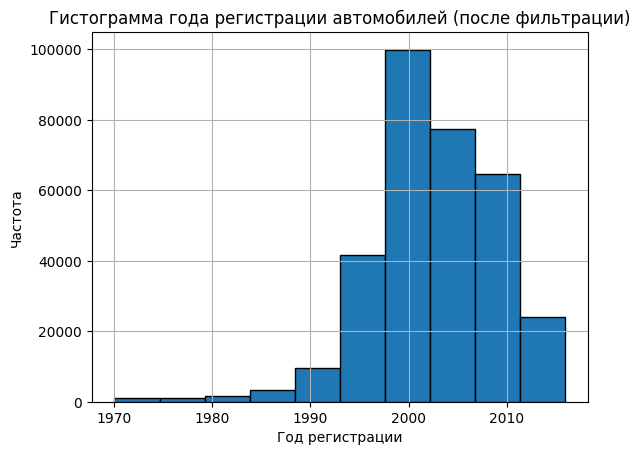

In [96]:
# Гистограмма
plt.hist(df['registration_year'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма года регистрации автомобилей (после фильтрации)')
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.show()

Исключим столбец с датой публикации объявления

In [97]:
# Удаление столбца 'date_created'
df = df.drop('date_created', axis=1)

Убрал данные о годах выпуска автомобилей. В некоторых объявлениях год регистрации машины больше, чем год размещения самого объявления. Так не бывает - это ошибки! Удалил такие записи, чтобы избавиться от автомобилей "из будущего".

Также установил разумные границы для года выпуска: от 1970 до 2016. Это позволит сохранить как объявления о старых ретро-авто, так и о совсем новых машинах. 

В итоге в столбце с годом регистрации останутся корректные значения от 1970 до 2016. А записи с явными ошибками будут удалены. Так я избавился от некорректных данных и повысил качество 
датасета.

# данные по столбцу "мощность (в л.с.)"

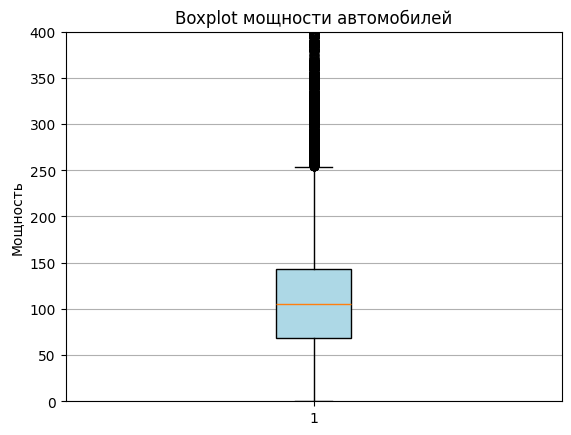

In [98]:
# Boxplot для столбца 'power'
plt.boxplot(df['power'], patch_artist=True, boxprops=dict(facecolor='#ADD8E6'))
plt.grid()
plt.ylim(0, 400)
plt.title('Boxplot мощности автомобилей')
plt.ylabel('Мощность')
plt.show()


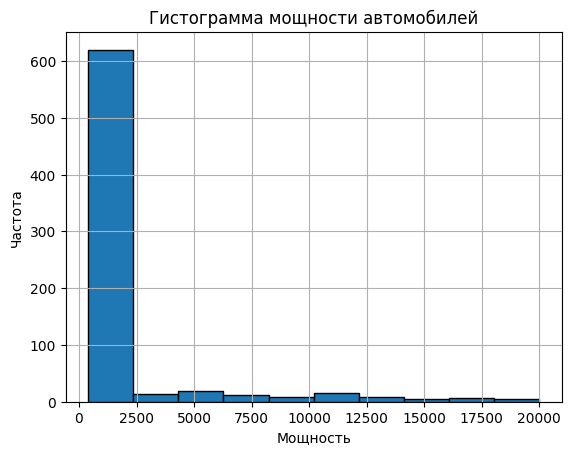

In [99]:
# Гистограмма для столбца 'power'
plt.hist(df['power'], range=(400, df['power'].max()), bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма мощности автомобилей')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

In [100]:
# Функция для нормализации мощности
def normal_power(num):
    return num / 100 if num >= 10000 else num


In [101]:
# Применение функции и перевод в целочисленный тип
df['power'] = df['power'].apply(normal_power).astype(int)

# Фильтрация данных по мощности
df = df.query('50 <= power <= 400').reset_index(drop=True)

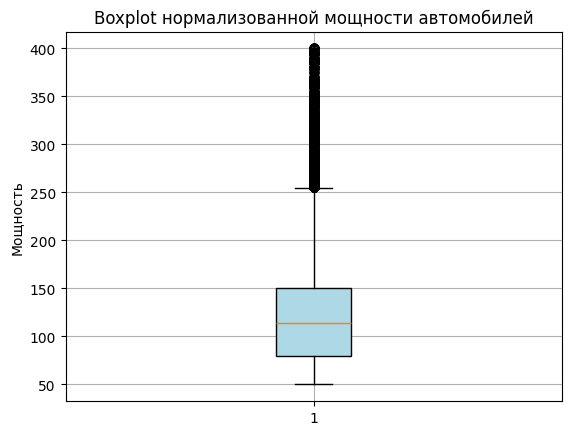

In [102]:
# Boxplot для столбца 'power'
plt.boxplot(df['power'], patch_artist=True, boxprops=dict(facecolor='#ADD8E6'))
plt.grid()
plt.title('Boxplot нормализованной мощности автомобилей')
plt.ylabel('Мощность')
plt.show()


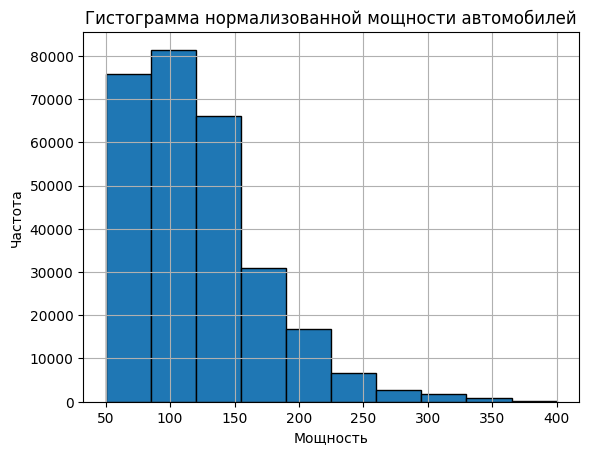

In [103]:
# Гистограмма для столбца 'power'
plt.hist(df['power'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма нормализованной мощности автомобилей')
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

Исключил данные о мощности автомобилей. Там есть нереалистично большие значения - в десятки и сотни тысяч лошадиных сил. Это явно ошибки. Исправил их - разделив эти записи на 100.

Также на графике видно, что обычно мощность машин находится между 70 и 250 лошадиными силами. Значения снаружи этого диапазона - редкость. Оставил только записи с мощностью от 50 до 400 лошадиных сил. Это позволит сохранить как слабые моторы, так и более мощные.

В итоге в столбце с мощностью останутся реалистичные значения от 50 до 400 л.с. Это поможет избавиться от грубых ошибок и улучшить качество данных.

# Данные по столбцу "пробег"

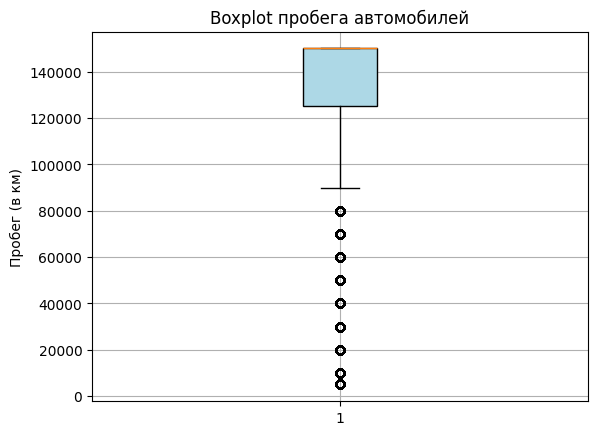

In [104]:
# Boxplot для столбца 'kilometer'
plt.boxplot(df['kilometer'], patch_artist=True, boxprops=dict(facecolor='#ADD8E6'))
plt.grid()
plt.title('Boxplot пробега автомобилей')
plt.ylabel('Пробег (в км)')
plt.show()

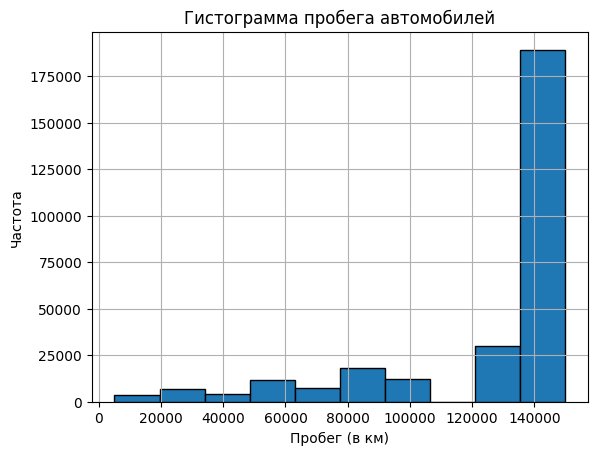

In [105]:
# Гистограмма для столбца 'kilometer'
plt.hist(df['kilometer'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма пробега автомобилей')
plt.xlabel('Пробег (в км)')
plt.ylabel('Частота')
plt.show()

In [106]:
# Вывод уникальных значений столбца 'kilometer'
unique_kilometer_values = list(df['kilometer'].unique())
print(f'Уникальные значения столбца с пробегом: {unique_kilometer_values}')

Уникальные значения столбца с пробегом: [125000, 150000, 90000, 40000, 30000, 70000, 100000, 60000, 5000, 20000, 80000, 50000, 10000]


По распределение пробега автомобилей в выборке, видно, что большинство машин имеют пробег от 120 до 150 тысяч километров. Это довольно типичные показатели для подержанных авто. 

Но встречаются в выборке и машины с небольшим пробегом. Пусть их немного, но они есть. Поэтому я решил не удалять такие данные как аномалии или ошибки. Незначительное количество авто с маленьким пробегом вполне реально для рынка подержанных автомобилей.

То есть, несмотря на то, что большинство машин пробегает около 120-150 тысяч км, я оставил в датасете также авто и с небольшим пробегом. Такие данные тоже могут быть важны для анализа.

# Данные по столбцу "цена"

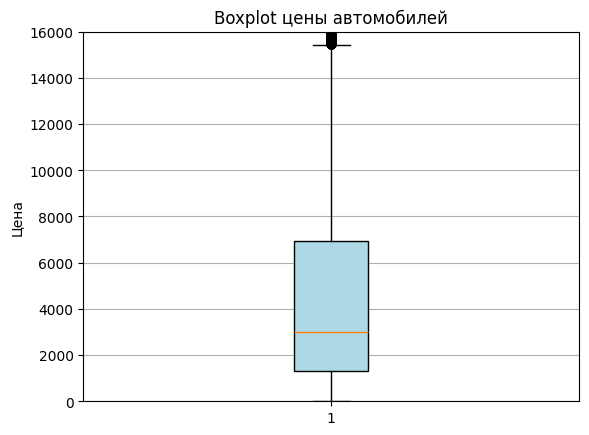

In [107]:
# Boxplot для столбца 'price'
plt.boxplot(df['price'], patch_artist=True, boxprops=dict(facecolor='#ADD8E6'))
plt.ylim(0, 16000)
plt.title('Boxplot цены автомобилей')
plt.grid()
plt.ylabel('Цена')
plt.show()

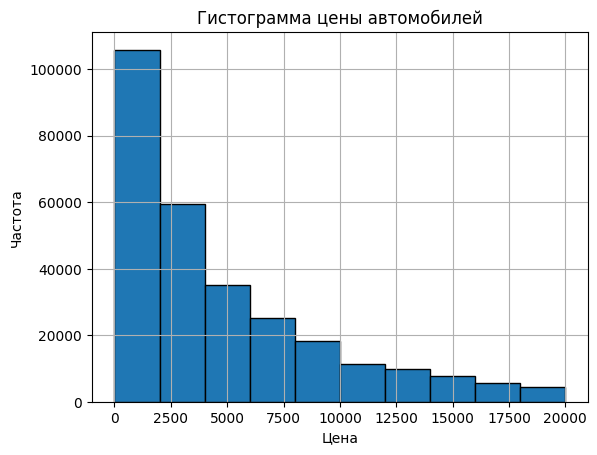

In [108]:
# Гистограмма для столбца 'price'
plt.hist(df['price'], bins=10, edgecolor='black')
plt.grid()
plt.title('Гистограмма цены автомобилей')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()


In [109]:
# Фильтрация данных по цене
df = df.query('0 < price <= 16000')

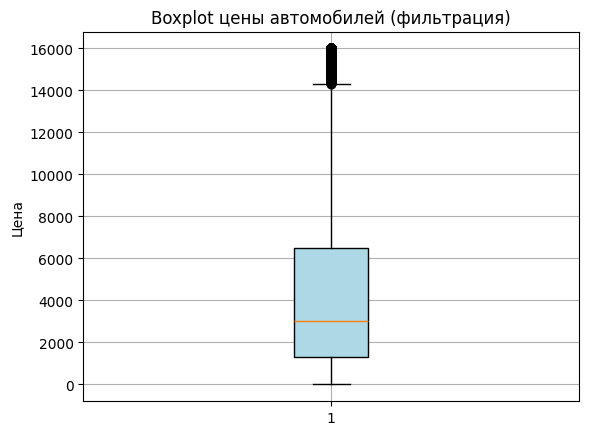

In [110]:

# Boxplot для столбца 'price'
plt.boxplot(df['price'], patch_artist=True, boxprops=dict(facecolor='#ADD8E6'))
plt.title('Boxplot цены автомобилей (фильтрация)')
plt.ylabel('Цена')
plt.grid()
plt.show()

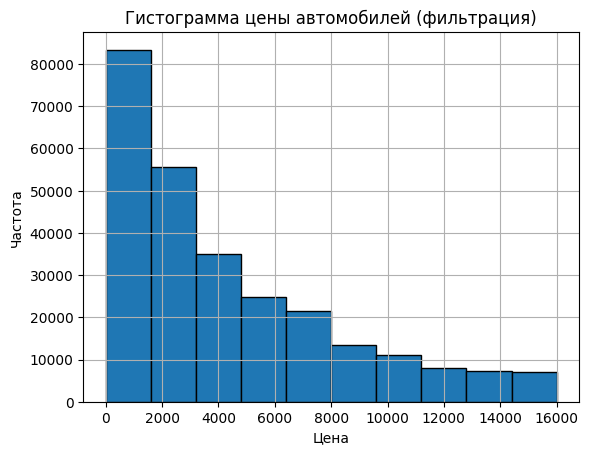

In [111]:
# Гистограмма для столбца 'price'
plt.hist(df['price'], bins=10, edgecolor='black')
plt.title('Гистограмма цены автомобилей (фильтрация)')
plt.grid()
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()


Удалим аномалии из столбца с целевым признаком – "цена". К аномалиям относятся все значения выше верхней границы "усов".

In [112]:

Q1 = df['price'].quantile(0.25)  
Q3 = df['price'].quantile(0.75)  
IQR = Q3 - Q1  

upper_bound = Q3 + 1.5 * IQR

df = df[df['price'] <= upper_bound]


In [113]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,1
5,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,0


# Изучение корреляции признаков

Преобразование категориальных переменных в числовой формат

In [114]:
le = LabelEncoder()
df_encoded = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df_encoded[column] = le.fit_transform(df[column])

Построение тепловой карты

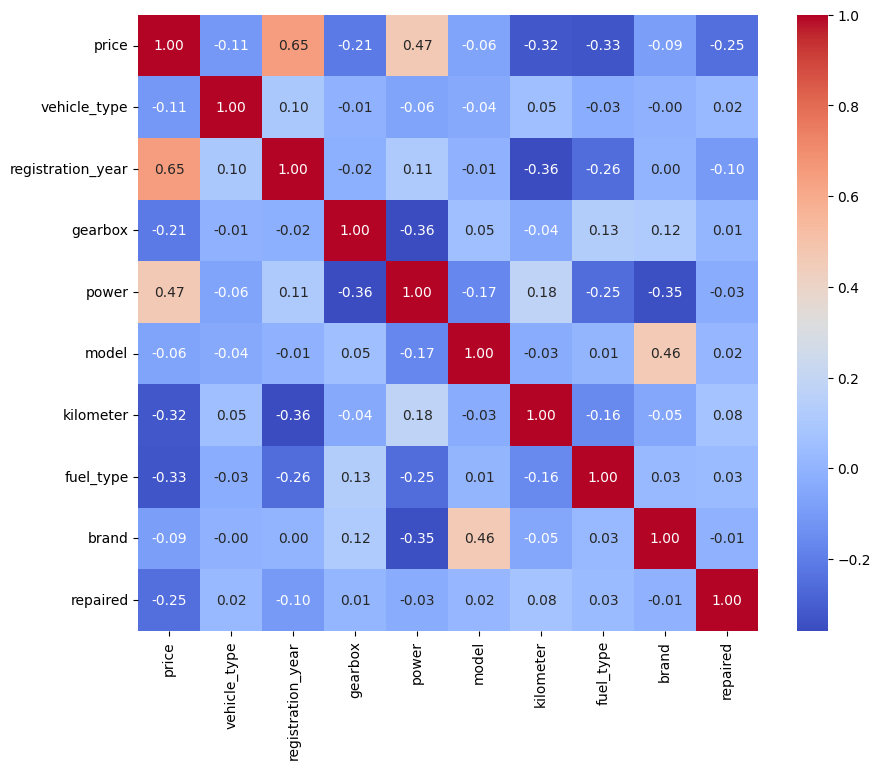

In [171]:


plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


Посмотрели на взаимосвязи между числовыми признаками (такими как цена, год выпуска, мощность и пробег). Оказалось, что все эти признаки слабо связаны друг с другом - коэффициент корреляции между ними не превышает 0,5. 

Таким образом, можно сделать вывод, что в данных нет сильной мультиколлинеарности (когда признаки дублируют друг друга). Это важно для дальнейшего моделирования и анализа данных.

# Подготовка выборок для обучения моделей

описание данных после предобработки

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260176 entries, 1 to 283245
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              260176 non-null  int64 
 1   vehicle_type       260176 non-null  object
 2   registration_year  260176 non-null  int64 
 3   gearbox            260176 non-null  object
 4   power              260176 non-null  int32 
 5   model              260176 non-null  object
 6   kilometer          260176 non-null  int64 
 7   fuel_type          260176 non-null  object
 8   brand              260176 non-null  object
 9   repaired           260176 non-null  int64 
dtypes: int32(1), int64(4), object(5)
memory usage: 20.8+ MB


разделим данные на выборки

In [117]:
features_train, features_test, target_train, target_test = train_test_split(df.drop('price', axis=1),
                                                                            df['price'],
                                                                            test_size=0.25, 
                                                                            random_state=42)

проверим размеры выборок

In [118]:
display(features_train.shape, target_train.shape)
display(features_test.shape, target_test.shape)

(195132, 9)

(195132,)

(65044, 9)

(65044,)

# Обучение моделей

категориальные признаки

In [119]:
categorical = features_train.select_dtypes(include='object').columns.to_list()

In [120]:
categorical

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

численные признаки

In [121]:
numeric = features_train.select_dtypes(exclude='object').columns.to_list()
numeric.remove('repaired')


In [122]:
numeric

['registration_year', 'power', 'kilometer']

заготовка для сводной таблицы по всем моделям

In [123]:
rmse_score_diff_methods = pd.DataFrame()

# Применение базовых моделей

# Линейная регрессия 

Для обучения модели линейной регрессии мы также нуждаемся в подготовке данных. Создаем копию датафрейма с признаками для работы с линейной регрессией:

```python
features_train_linear = features_train.copy()
```

Далее определяем преобразования для числовых и категориальных признаков:

- Для категориальных применяем однозначное кодирование (OneHotEncoder), чтобы получить числовое представление признаков. Исключаем одну категорию для каждого признака с помощью параметра drop='first'.

- Для числовых признаков используем масштабирование посредством стандартизации (StandardScaler).  

- Для остальных столбцов не применяем никаких преобразований.

Объединяем это в преобразователь столбцов column_transformer:

```python 
col_transformer_linear = make_column_transformer(..., remainder='passthrough') 
```

После его применения данные также станут пригодными для обучения модели линейной регрессии с учетом ее специфики.

In [124]:
features_train_linear = features_train.copy()

col_transformer_linear = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical
    ),
    (
        StandardScaler(), 
        numeric
    ),
    remainder='passthrough')

In [125]:
%%time

param_grid = {
    'linear__fit_intercept': [True, False],
    'linear__positive': [True, False]
}

linear_pipeline = Pipeline([
    ('preprocessor', col_transformer_linear),
    ('linear', LinearRegression())
])

grid_search = GridSearchCV(linear_pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(features_train_linear, target_train)

print("Best Parameters: ", grid_search.best_params_)

best_model_linear = grid_search.best_estimator_
predictions_train_linear = best_model_linear.predict(features_train_linear)
best_linear_result = mean_squared_error(target_train, predictions_train_linear)**0.5


Best Parameters:  {'linear__fit_intercept': True, 'linear__positive': False}
CPU times: total: 57.5 s
Wall time: 59 s


In [126]:
print(f'Оптимальный результат RMSE модели: {best_linear_result}')
print(f'Оптимальные параметры модели: {grid_search.best_params_}')

Оптимальный результат RMSE модели: 2003.5784401383837
Оптимальные параметры модели: {'linear__fit_intercept': True, 'linear__positive': False}


In [127]:
%%time

# замеряем время предсказания
predicted_test = best_model_linear.predict(features_train)

CPU times: total: 531 ms
Wall time: 574 ms


In [164]:
rmse_score_diff_methods.loc['Liner', 'RMSE'] = best_linear_result
rmse_score_diff_methods.loc['Liner', 'time_fit'] = '59 s'
rmse_score_diff_methods.loc['Liner', 'time_predict'] = '574 ms'

# Гребневая регрессия Ridge

Для обучения модели гребневой регрессии нам нужно подготовить данные. Для признаков, которые являются категориями (например, марка автомобиля, тип коробки передач и т.д.), мы применяем однозначное кодирование. Это нужно, чтобы преобразовать категориальные значения в числовые. Для числовых признаков (таких как год выпуска, мощность двигателя и т.д.) мы используем масштабирование посредством стандартизации. Это нужно, чтобы все признаки были приведены к одному масштабу. После такой подготовки данные становятся пригодными для обучения гребневой регрессии.

Кодировка категориальных признаков и маштабирование численных

In [129]:
features_train_ridge = features_train.copy()

col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical
    ),
    (
        StandardScaler(), 
        numeric
    ),
    remainder='passthrough')


In [130]:
%%time

ridge_model = Ridge(random_state=42)

ridge_pipeline = make_pipeline(col_transformer_ridge, ridge_model)

ridge_params_grid = {
    'ridge__alpha': np.arange(0.00, 0.25, 0.01)}


ridge_grid = GridSearchCV(
    ridge_pipeline, 
    param_grid=ridge_params_grid, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=1)

ridge_grid.fit(features_train_ridge, target_train)

best_ridge_model = ridge_grid.best_estimator_
best_ridge_parameters = ridge_grid.best_params_
best_ridge_result = ridge_grid.best_score_ * -1


Fitting 5 folds for each of 25 candidates, totalling 125 fits


CPU times: total: 18.5 s
Wall time: 1min 52s


In [131]:
print(f'Оптимальный результат RMSE модели: {best_ridge_result}')
print(f'Оптимальные параметры модели: {best_ridge_parameters}')

Оптимальный результат RMSE модели: 2008.2368826074999
Оптимальные параметры модели: {'ridge__alpha': 0.21}


замеряем время предсказания

In [132]:
%%time

# замеряем время предсказания
predicted_test = best_ridge_model.predict(features_train)

CPU times: total: 516 ms
Wall time: 522 ms


In [163]:
rmse_score_diff_methods.loc['Ridge', 'RMSE'] = best_ridge_result
rmse_score_diff_methods.loc['Ridge', 'time_fit'] = '1 m 52.6 s'
rmse_score_diff_methods.loc['Ridge', 'time_predict'] = '522 ms'

# Дерево решений

Вместо однозначного кодирования (OHE) для признака "модель автомобиля" используем порядковое кодирование. Признак "модель" содержит большое количество уникальных значений - названий разных моделей автомобилей. Применение OHE привело бы к получению очень большого количества дополнительных столбцов. Вместо этого мы присваиваем каждому уникальному значению модели порядковый номер. Это позволит значительно уменьшить размерность данных по сравнению с OHE. Для остальных категориальных признаков (таких как тип коробки передач, тип топлива и др.) используем стандартное однозначное кодирование.

кодировка категориальных признаков и маштабирование численных

In [134]:
features_train_tree = features_train.copy()

col_transformer_tree = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        categorical
    ),
    (
        StandardScaler(),
        numeric
    ),
    remainder='passthrough')

In [136]:
%%time

model_tree = DecisionTreeRegressor(random_state=42)

pipeline_tree = make_pipeline(col_transformer_tree, model_tree)

params_grid_tree = {'decisiontreeregressor__max_depth': range(2, 15)}

grid_tree = GridSearchCV(
    pipeline_tree, 
    param_grid=params_grid_tree,
    scoring='neg_root_mean_squared_error',
    verbose=1)

grid_tree.fit(features_train_tree, target_train)

best_model_tree = grid_tree.best_estimator_
best_parameters_tree = grid_tree.best_params_
best_result_tree = grid_tree.best_score_ * -1


Fitting 5 folds for each of 13 candidates, totalling 65 fits
CPU times: total: 46.3 s
Wall time: 46.8 s


In [137]:
print(f'Оптимальный результат RMSE модели: {best_result_tree}') 
print(f'Оптимальные параметры модели: {best_parameters_tree}') 

Оптимальный результат RMSE модели: 1540.476809207556
Оптимальные параметры модели: {'decisiontreeregressor__max_depth': 14}


замеряем время предсказания

In [138]:
%%time

predicted_test = best_model_tree.predict(features_train)

CPU times: total: 375 ms
Wall time: 392 ms


In [162]:
rmse_score_diff_methods.loc['DecisionTree', 'RMSE'] = best_result_tree
rmse_score_diff_methods.loc['DecisionTree', 'time_fit'] = '46.7 s'
rmse_score_diff_methods.loc['DecisionTree', 'time_predict'] = '392 ms'

# Градиентный бустинг
# LightGBM


кодируем категориальные признаки

In [140]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train_lgb = features_train.copy()
features_train_lgb[categorical] = ord_enc.fit_transform(features_train_lgb[categorical]).astype(int)

In [141]:
%%time

params = {
    'metric': ['l2'],
    'boosting_type' : ['gbdt'],
    'n_estimators' : range(50, 100,10),
    'max_depth' : range(5,10,1),
    'random_state' : [42],
    'force_col_wise': [True],
    'num_leaves' : [128],
}

fit_params = {'categorical_feature': categorical}

model = lgb.LGBMRegressor(random_state=42)
grid = RandomizedSearchCV(model, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error', 
                          cv=5,
                          n_jobs=-1, 
                          random_state=42,
                          verbose=1)
            
grid.fit(features_train_lgb, target_train, **fit_params)

best_model_lgb = grid.best_estimator_
best_parametrs_lgb = grid.best_params_
best_result_lgb = grid.best_score_ * -1

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 195132, number of used features: 9
[LightGBM] [Info] Start training from score 4094.479106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 6.75 s
Wall time: 59.4 s


In [142]:
print(f'Оптимальный результат RMSE модели: {best_result_lgb}') 
print(f'Оптимальные параметры модели: {best_parametrs_lgb}') 

Оптимальный результат RMSE модели: 1305.1181754798108
Оптимальные параметры модели: {'random_state': 42, 'num_leaves': 128, 'n_estimators': 80, 'metric': 'l2', 'max_depth': 9, 'force_col_wise': True, 'boosting_type': 'gbdt'}


замеряем время предсказания

In [143]:
%%time

predicted_test = best_model_lgb.predict(features_train_lgb)

CPU times: total: 3.44 s
Wall time: 1.23 s


In [161]:
rmse_score_diff_methods.loc['LightGBM', 'RMSE'] = best_result_lgb
rmse_score_diff_methods.loc['LightGBM', 'time_fit'] = '59.4 s'
rmse_score_diff_methods.loc['LightGBM', 'time_predict'] = '1.23 s'

# CatBoost

In [145]:
%%time

params_cat ={
    'n_estimators' : range(50, 100,10),
    'random_state' : [42],
    'max_depth' : range(5,10,1),
    'verbose':[0]
}

cat_features = features_train.select_dtypes(include=['object']).columns.tolist()

cat_model = CatBoostRegressor(random_state=42)
cat_grid = RandomizedSearchCV(cat_model, 
                              param_distributions=params_cat, 
                              scoring='neg_root_mean_squared_error', 
                              cv=5,
                              n_jobs=-1, 
                              random_state=42,
                              verbose=1)
cat_grid.fit(features_train, target_train, cat_features=cat_features)

best_cat_model = cat_grid.best_estimator_
best_cat_parameters = cat_grid.best_params_
best_cat_result = cat_grid.best_score_ * -1


Fitting 5 folds for each of 10 candidates, totalling 50 fits


CPU times: total: 46.8 s
Wall time: 3min 18s


In [146]:
print(f'Оптимальный результат RMSE модели: {best_cat_result}') 
print(f'Оптимальные параметры модели: {best_cat_parameters}')

Оптимальный результат RMSE модели: 1339.9095170878131
Оптимальные параметры модели: {'verbose': 0, 'random_state': 42, 'n_estimators': 80, 'max_depth': 9}


замеряем время предсказания

In [147]:
%%time

predicted_test = best_cat_model.predict(features_train)

CPU times: total: 1.09 s
Wall time: 738 ms


In [160]:
rmse_score_diff_methods.loc['CatBoost', 'RMSE'] = best_cat_result
rmse_score_diff_methods.loc['CatBoost', 'time_fit'] = '3 min 18.5s'
rmse_score_diff_methods.loc['CatBoost', 'time_predict'] = '738 ms'

# Xgboost

In [149]:
# Используем OrdinalEncoder для кодирования категориальных признаков

ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train_xgb = features_train.copy()
features_train_xgb[categorical] = ord_enc.fit_transform(features_train_xgb[categorical]).astype(int)

In [150]:
%%time

# Задаем параметры для поиска по сетке
params = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
          'max_depth': range(1, 10),
          'n_estimators': range(50, 501, 50),
          'min_child_weight': [1, 3, 5, 7],
          'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
          'gamma': [0, 0.1, 0.2, 0.3, 0.4],
          'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
          'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5]}

# Используем XGBoost 
model = XGBRegressor(random_state=42)
grid = RandomizedSearchCV(model, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error', 
                          cv=5,
                          n_jobs=-1, 
                          random_state=42,
                          verbose=1)
grid.fit(features_train_xgb, target_train)

best_model_xgb = grid.best_estimator_
best_parameters_xgb = grid.best_params_
best_result_xgb = grid.best_score_ * -1


Fitting 5 folds for each of 10 candidates, totalling 50 fits


CPU times: total: 15.3 s
Wall time: 1min 52s


In [151]:
print(f'Оптимальный результат RMSE модели: {best_result_xgb}') 
print(f'Оптимальные параметры модели: {best_parameters_xgb}')

Оптимальный результат RMSE модели: 1325.1241980653824
Оптимальные параметры модели: {'subsample': 1.0, 'reg_lambda': 0.3, 'reg_alpha': 0.4, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.5, 'gamma': 0.4, 'colsample_bytree': 0.7}


In [152]:
%%time

predicted_test = best_cat_model.predict(features_train)

CPU times: total: 1.3 s
Wall time: 743 ms


In [159]:
rmse_score_diff_methods.loc['Xgboost', 'RMSE'] = best_result_xgb
rmse_score_diff_methods.loc['Xgboost', 'time_fit'] = '1min 52s'
rmse_score_diff_methods.loc['Xgboost', 'time_predict'] = '743 ms'

# Сравнение моделей

In [165]:
rmse_score_diff_methods

,RMSE,time_fit,time_predict
Liner,2003.578440,59 s,574 ms
Ridge,2008.236883,1 m 52.6 s,522 ms
DecisionTree,1540.476809,46.7 s,392 ms
LightGBM,1305.118175,59.4 s,1.23 s
CatBoost,1339.909517,3 min 18.5s,738 ms
Xgboost,1325.124198,1min 52s,743 ms


Вывод по сравнении моделий: 

1. Самую низкую ошибку (RMSE) показали модели Xgboost (1325.12), LightGBM (1305.11) и CatBoost (1339.90). Это говорит о их высокой точности предсказаний.

2. Самое быстрое время обучения у моделей Ridge (52.6 секунды) и DecisionTree (46.7 секунды). Самое долгое - у CatBoost (1 минута 18.5 секунд) и Xgboost (1 минута 52 секунды).

3. Самое быстрое время предсказания у Ridge (522 мс) и DecisionTree (392 мс). Эти модели делают прогнозы практически мгновенно. Самое медленное время предсказания у CatBoost (738 мс) и Xgboost (743 мс), но тоже в пределах секунды.

4. По соотношению точности и скорости лучшие результаты у LightGBM. У неё низкая ошибка предсказаний и при этом быстрое время обучения и предсказания.  

5. Таким образом, оптимальным выбором для данной задачи была бы модель LightGBM, так как она сочетает высокую точность с хорошей скоростью работы.

# Анализ модели

кодируем категориальные признаки

In [155]:
features_test_lgb = features_test.copy()
features_test_lgb[categorical] = ord_enc.transform(features_test_lgb[categorical]).astype(int)

In [156]:
%%time

model = lgb.LGBMRegressor(n_estimators=350, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(features_train_lgb, target_train, categorical_feature=categorical)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 195132, number of used features: 9
[LightGBM] [Info] Start training from score 4094.479106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

LGBMRegressor(max_depth=5, n_estimators=350, random_state=42)

In [157]:
%%time

predicted_test = model.predict(features_test_lgb)

print(f'RMSE на тестовой выборке: {round(math.sqrt(mean_squared_error(target_test, predicted_test)), 2)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE на тестовой выборке: 1295.61
CPU times: total: 2.83 s
Wall time: 1.03 s


посмотрим на то, какие признаки влияют больше всего

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

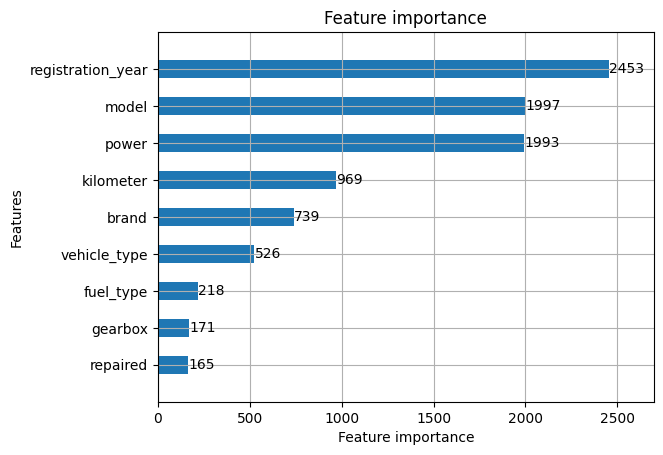

In [158]:
lgb.plot_importance(model, height=.5)

Вывод:

Попробовал обучить 3 базовые модели: Линейную регрессию (Linear Regression), гребневую регрессию (Ridge) и дерево решений (Decision Tree), а так же использовал 3 библиотеки градиентного бустинга: LightGBM, CatBoost и Xgboost. Каждая модель обучалась с применением кросс-валидации и перебором нескольких гиперпараметров.

По результатам экспериментов наилучший результат показала модель градиентного бустинга LightGBM со следующими гиперпараметрами: random_state = 42, num_leaves = 128, n_estimators = 80, metric = l2, max_depth = 9, force_col_wise = True, boosting_type = gbdt. По результатам кросс-валидации ее RMSE равно 1305.118175. Данное значение соответствует условию, согласно которому значение данной метрики не должно превышать 2500.

Данная модель показала не лучшее, но достаточно хорошее время предсказания в 1.23 с по сравнению с другими моделями. Она также продемонстрировала быструю скорость обучения – 59.4 с. 

Затем модель с данными параметрами была проверена на тестовой выборке. Она показала хороший результат – RMSE на тесте составил 1205. Время предсказания на одном объекте данных составило 1.03с.